# 學習日期: 2022/6/2開始
## 目標: 使用指定的backbone論文，進行口罩辨識
## Backbone論文: Network in Network
- **參考資料1:** https://hackmd.io/@shaoeChen/HJ19NfW4U
- **參考資料2:** https://github.com/jiecaoyu/pytorch-nin-cifar10
- **長青自製-口罩數據集:** https://drive.google.com/drive/folders/1lC_BVKHzEbtMEy8tibXAsJdrAs6fWuz5?usp=sharing

待處理:
adam, k-folder, other

## 0_修改程式 (傳送門)
- [1_設定參數](#1_設定參數)


- [2_資料前處理](#2_資料前處理)


- [3_訓練模型(train, val)](#3_訓練模型(train,val))


- [4_運行主程式](#4_運行主程式)


- [5_查看訓練結果](#5_查看訓練結果)


In [1]:
import torch, os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from NIN_v1_model import NIN_v1
from NIN_v2_model import NIN_v2
from InceptionV3_model import Inception
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import visdom  # 訓練即時可視化工具

### Visdom訓練過程即時可視化說明:
#### 1. 終端機輸入:
- `conda activate Py37` -- {environment name}
- `python -m visdom.server -port 8097` -- {port number}

#### 2. 網頁輸入:
- `http://localhost:8097`
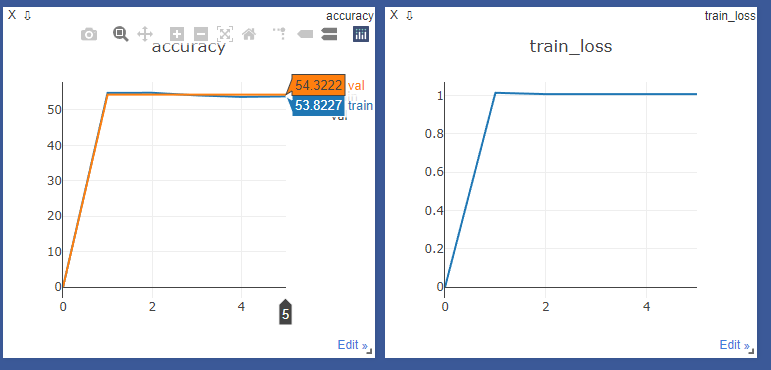

## 1_設定參數

In [2]:
# 設定參數--------------------------------------------------------------------
batch_size = 32
img_size = 224
lr = 0.01
epoch = 5
use_GPU = True
real_time_train_result = True  # 若不想開啟Visdom，就設為"False"
choose_model = 'NIN_v2'  # NIN_v1, NIN_v2, Inception

MODEL = 'best_model.pth'
classes = {0: 'cloth_mask', 1: 'face_no_mask', 2:'mask_surgical'}  # 設定dataset類別

# 強迫固定初始權重，方便研究用
np.random.seed(1)
torch.manual_seed(1)


## 2_資料前處理

In [3]:
# 資料前處理
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform_train = transforms.Compose([
    transforms.Resize((224,224)), # 強制224x224
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)), #長=256 寬=等比例縮小
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

train_data = datasets.ImageFolder('data/train/', transform=transform_train)
trainloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)  # shuffle: 每次batch_size取不同dataset

val_data = datasets.ImageFolder('data/val/', transform=transform_val)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

## 3_訓練模型(train,val)

In [4]:
# train_function_v1
def train(trainloader, model, use_GPU, epoch, loss_func, optimizer):
    model.train()
    correct, total = 0, 0
    acc_sum, loss_sum = 0, 0
    i = 0

    #accumulation_step = 2  #+++++++++++++++++++
    optimizer.zero_grad()
    for batch_idx, (data, target) in enumerate(trainloader):
        if use_GPU == True:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()  #----------------------
        output = model(data)

        # calculate accuracy
        correct += (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
        total += trainloader.batch_size
        train_acc = 100. * correct / total
        acc_sum += train_acc
        i += 1

        loss = loss_func(output, target)
        
        #loss = loss / accumulation_step  #+++++++++++++++++++++++++
        
        loss.backward()
        optimizer.step()  #-----------------
        loss_sum += loss.item()
        
        #++++++++++++++++++++++
        #if ((batch_idx+1) % accumulation_step == 0) or ((batch_idx+1)==len(trainloader)):
            #optimizer.step() # update
            #optimizer.zero_grad() # reset
        #++++++++++++++++++++++
        
        # 每跑100批batch_size查看一次
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}\tTraining Accuracy: {:.3f}%'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item(), train_acc))
    
    # 每回合eopch的train loss, accuracy
    acc_avg = acc_sum / i
    loss_avg = loss_sum / len(trainloader)

    print('Train Epoch: {}\tAverage Loss: {:.3f}\tAverage Accuracy: {:.3f}%'.format(epoch, loss_avg, acc_avg))
    
    return acc_avg, loss_avg

In [5]:
# val_function
def val(valloader, model, use_GPU, loss_func, epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valloader:
            if use_GPU == True:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            # sum up batch loss
            val_loss += loss_func(output, target).item()
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    val_loss /= len(valloader)
    val_acc = 100. * correct / len(valloader.dataset)
    result = '\nVal set -> Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        val_loss, correct, len(valloader.dataset), val_acc)
    print(result)
    return val_acc

## 4_運行主程式

In [6]:
# main---------------------------------------------
# 選擇訓練模型
if choose_model == 'NIN_v1':
    net = NIN_v1(num_classes=len(classes))
elif choose_model == 'NIN_v2':
    net = NIN_v2(num_classes=len(classes))
elif choose_model == 'Inception':
    net = Inception(pretrained=0, num_classes=len(classes))
net.cuda()

# 優化器
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# 保存loss歷史數據，plt看圖用
train_loss_list = np.zeros(epoch+1)
train_acc_list = np.zeros(epoch+1)
val_acc_list = np.zeros(epoch+1)

# 在訓練的過程中會根據驗證集的最佳準確率保存模型
best_val_correct_rate = 0.0

#訓練可視化-初始化窗口----------------------------------------------------
if real_time_train_result == True:
    vis = visdom.Visdom(server='http://localhost', port=8097, env='main')
    vis.line([[0., 0.]], [0], win='accuracy', opts=dict(title='accuracy', legend = ['train','val']))   # [y軸1,y軸2][x軸] legend=標籤
    vis.line([0.], [0], win='train_loss', opts=dict(title='train_loss'))   # [y軸][x軸] 
#------------------------------------------------------------------------

for epoch in range (1, epoch + 1):
    acc_avg, loss_avg = train(trainloader, net, use_GPU, epoch, loss_func, optimizer)
    val_acc = val(valloader, net, use_GPU, loss_func, epoch)
    
    train_loss_list[epoch] = loss_avg  # 保存loss history
    train_acc_list[epoch] = acc_avg  # 保存loss history
    val_acc_list[epoch] = val_acc  # 保存loss_val history
    
    #即時可視化訓練過程(accuracy, loss)-------------------------------------------------
    if real_time_train_result == True:
        vis.line([[acc_avg.item(), val_acc.item()]], [epoch], win='accuracy', update='append')  # 添加訊息到初始化的窗口
        vis.line([loss_avg], [epoch], win='train_loss', update='append')  # 添加訊息到初始化的窗口
    #----------------------------------------------------------------------------------
    
    # 保存最佳模型
    if val_acc > best_val_correct_rate:
        best_val_correct_rate = val_acc
        # 每回合結束，保存最佳模型
        torch.save(net.state_dict(), MODEL)
        
print('train finished.')
print("\a")  # 訓練完，提示音提醒我~

Setting up a new session...


Train Epoch: 1 [0/4074 (0%)]	Loss: 1.084	Training Accuracy: 59.375%
Train Epoch: 1 [3200/4074 (78%)]	Loss: 0.989	Training Accuracy: 54.394%
Train Epoch: 1	Average Loss: 1.019	Average Accuracy: 54.846%

Val set -> Average loss: 1.0037, Accuracy: 553/1018 (54.322%)

Train Epoch: 2 [0/4074 (0%)]	Loss: 1.043	Training Accuracy: 50.000%
Train Epoch: 2 [3200/4074 (78%)]	Loss: 1.046	Training Accuracy: 54.455%
Train Epoch: 2	Average Loss: 1.008	Average Accuracy: 53.329%

Val set -> Average loss: 1.0037, Accuracy: 553/1018 (54.322%)

Train Epoch: 3 [0/4074 (0%)]	Loss: 0.961	Training Accuracy: 59.375%
Train Epoch: 3 [3200/4074 (78%)]	Loss: 0.912	Training Accuracy: 54.827%
Train Epoch: 3	Average Loss: 1.005	Average Accuracy: 55.628%

Val set -> Average loss: 1.0039, Accuracy: 553/1018 (54.322%)

Train Epoch: 4 [0/4074 (0%)]	Loss: 0.886	Training Accuracy: 68.750%
Train Epoch: 4 [3200/4074 (78%)]	Loss: 1.072	Training Accuracy: 54.425%
Train Epoch: 4	Average Loss: 1.007	Average Accuracy: 54.803%

Val

## 5_查看訓練結果

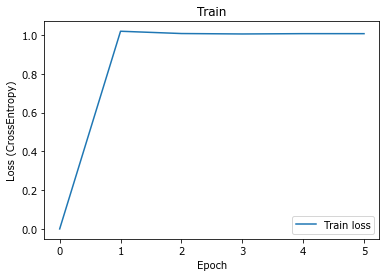

In [7]:
plt.plot(train_loss_list, label='Train loss')
plt.title('Train')
plt.xlabel("Epoch")
plt.ylabel("Loss (CrossEntropy)")
#plt.ylim((0, 2))
plt.legend()  # 顯示標籤

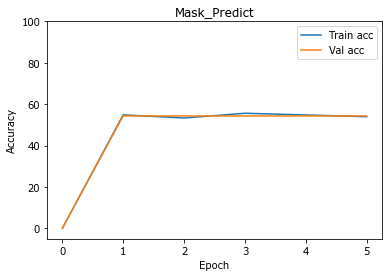

[WinError 10054] 遠端主機已強制關閉一個現存的連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 

on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close() takes 1 positional argument but 3 were given
[WinError 10061] 無法連線，因為目標電腦拒絕連線。
on_close()

In [8]:
plt.plot(train_acc_list, label='Train acc')
plt.plot(val_acc_list, label='Val acc')
plt.title('Mask_Predict')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim((-5, 100))  # 限制範圍
plt.legend()  # 顯示標籤